### Imports

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import date
from datetime import datetime
from scipy.stats import norm

/Users/aayushkhandekar/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


### Get NVDA Data - stock and options

expiration date = 2025-08-01

In [2]:
ticker = yf.Ticker('NVDA')

expiration_date = '2025-08-01'

options = ticker.option_chain(expiration_date)

calls = options.calls

puts = options.puts

calls['Option'] = 'C'

puts['Option'] = 'P'

options = pd.concat(objs=[calls, puts], ignore_index=True)

### Black-Scholes Model

- We use BSM to understand, compare and make decisions based on the prices calculated.

- The market can be distorted due to various reasons which is why we calculate the fair theoretical fair price for the options and make our comparisons.

- We can calculate the implied volatility using the market price of the option with the help of BSM.

In [3]:
class BlackScholesModel:

    def __init__(self):
        pass

    def d1(self, S0, K, T, r, sigma):
        return (np.log(S0 / K) + (r + 0.5 * (sigma ** 2)) * T) / (sigma * np.sqrt(T))
    
    def d2(self, S0, K, T, r, sigma):
        return self.d1(S0, K, T, r, sigma) - (sigma * np.sqrt(T))
    
    def call_price(self, S0, K, T, r, sigma):
        d1 = self.d1(S0, K, T, r, sigma)
        d2 = self.d2(S0, K, T, r, sigma)
        return (S0 * norm.cdf(d1)) - (K * np.exp(-r * T) * norm.cdf(d2))
    
    def put_price(self, S0, K, T, r, sigma):
        d1 = self.d1(S0, K, T, r, sigma)
        d2 = self.d2(S0, K, T, r, sigma)
        return (-S0 * norm.cdf(-d1)) + (K * np.exp(-r * T) * norm.cdf(-d2))

bsm = BlackScholesModel()

In [4]:
options.head()

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency,Option
0,NVDA250801C00020000,2025-07-10 19:54:31+00:00,20.0,144.15,144.70,145.35,0.0,0.0,3.0,22,3.578126,True,REGULAR,USD,C
1,NVDA250801C00055000,2025-07-02 19:50:00+00:00,55.0,102.55,109.80,110.45,0.0,0.0,1.0,6,2.052739,True,REGULAR,USD,C
2,NVDA250801C00065000,2025-06-25 18:01:46+00:00,65.0,88.15,98.35,100.45,0.0,0.0,NaN,1,2.031255,True,REGULAR,USD,C
3,NVDA250801C00075000,2025-07-01 19:40:06+00:00,75.0,78.93,89.85,90.45,0.0,0.0,7.0,11,1.531252,True,REGULAR,USD,C
4,NVDA250801C00080000,2025-07-07 13:51:52+00:00,80.0,79.21,84.85,85.45,0.0,0.0,4.0,70,1.416019,True,REGULAR,USD,C


### Assumptions and parameters

In [5]:
today_date = datetime.strptime(date.today().strftime("%Y-%m-%d"), "%Y-%m-%d") 
expiration_date = datetime.strptime(expiration_date, "%Y-%m-%d")
days_to_expiry = (expiration_date - today_date).days
days_to_expiry

r = 0.05
lot = 100
num_contracts = 1
lots = lot * num_contracts
T = days_to_expiry/365
S0 = ticker.history(period='1d')['Close'].iloc[-1]
S_data = yf.download("NVDA", start="2022-01-01", end="2025-01-01")
S_dates = S_data.index


[*********************100%***********************]  1 of 1 completed

YF.download() has changed argument auto_adjust default to True


In [6]:
def theoretical_option_price(row):
    K = row['strike']
    sigma = row['impliedVolatility']
    if row['Option'] == 'C':
        return bsm.call_price(S0, K, T, r, sigma)
    return bsm.put_price(S0, K, T, r, sigma)

options['theoreticalPriceBSM'] = options.apply(theoretical_option_price, axis=1)

### Greeks

- Delta: Change in option price relative to a $1 move in the underlying [-1,1]

- Gamma: Change in delta as the underlying price changes

- Theta: The amount of value the option will lose each day as it closes to expiry. The rate of change increases as it approaches expiry.

- Vega: Sensitivity of the option's price to the chnages in the expected market volatility.

In [7]:
class OptionGreeks:
    
    def __init__(self):
        pass

    def d1(self, S0, K, T, r, sigma):
        return (np.log(S0 / K) + (r + 0.5 * (sigma ** 2)) * T) / (sigma * np.sqrt(T))
    
    def d2(self, S0, K, T, r, sigma):
        return self.d1(S0, K, T, r, sigma) - (sigma * np.sqrt(T))
    
    def delta(self, S0, K, T, r, sigma, option_type):
        d1 = self.d1(S0, K, T, r, sigma)
        if option_type == 'C':
            return norm.cdf(d1)
        return norm.cdf(d1) - 1
    
    def gamma(self, S0, K, T, r, sigma):
        d1 = self.d1(S0, K, T, r, sigma)
        return norm.pdf(d1) / (S0 * sigma * np.sqrt(T))
    
    def theta(self, S0, K, T, r, sigma, option_type):
        d1 = self.d1(S0, K, T, r, sigma)
        d2 = self.d2(S0, K, T, r, sigma)
        first_term = - (S0 * norm.pdf(d1) * sigma) / (2 * np.sqrt(T))
        if option_type == 'C':
            second_term = - r * K * np.exp(-r * T) * norm.cdf(d2)
        else:
            second_term = r * K * np.exp(-r * T) * norm.cdf(-d2)
        return first_term + second_term  

    def vega(self, S0, K, T, r, sigma):
        d1 = self.d1(S0, K, T, r, sigma)
        return S0 * norm.pdf(d1) * np.sqrt(T)

og = OptionGreeks()

def option_delta(row):
    K = row['strike']
    sigma = row['impliedVolatility']
    option_type = row['Option']
    return og.delta(S0, K, T, r, sigma, option_type)

def option_gamma(row):
    K = row['strike']
    sigma = row['impliedVolatility']
    return og.gamma(S0, K, T, r, sigma)

def option_theta(row):
    K = row['strike']
    sigma = row['impliedVolatility']
    option_type = row['Option']
    return og.theta(S0, K, T, r, sigma, option_type)

def option_vega(row):
    K = row['strike']
    sigma = row['impliedVolatility']
    return og.vega(S0, K, T, r, sigma)

options['delta'] = options.apply(option_delta, axis=1) 

options['gamma'] = options.apply(option_gamma, axis=1) 

options['theta'] = options.apply(option_theta, axis=1)

options['vega'] = options.apply(option_vega, axis=1)

### Analyzing Greeks

1. Greeks vs Strike Price (Call Options)

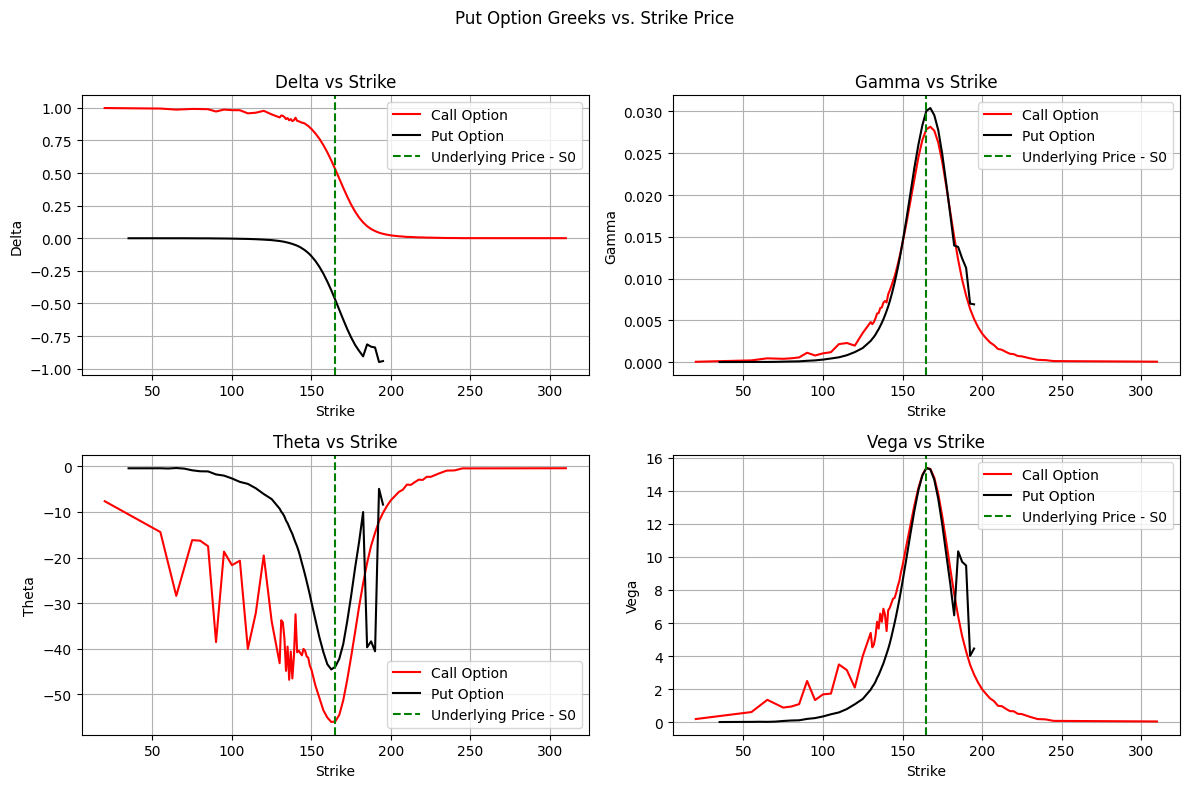

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle('Put Option Greeks vs. Strike Price')

calls = options[options['Option'] == 'C']
puts = options[options['Option'] == 'P']

# Delta
axs[0, 0].plot(calls['strike'], calls['delta'], label='Call Option', color='red')
axs[0, 0].plot(puts['strike'], puts['delta'], label='Put Option', color='black')
axs[0, 0].axvline(S0, label='Underlying Price - S0', color='green', linestyle='--')
axs[0, 0].set_title('Delta vs Strike')
axs[0, 0].set_xlabel('Strike')
axs[0, 0].set_ylabel('Delta')
axs[0, 0].legend()
axs[0, 0].grid(True)

# Gamma
axs[0, 1].plot(calls['strike'], calls['gamma'], label='Call Option', color='red')
axs[0, 1].plot(puts['strike'], puts['gamma'], label='Put Option', color='black')
axs[0, 1].axvline(S0, label='Underlying Price - S0', color='green', linestyle='--')
axs[0, 1].set_title('Gamma vs Strike')
axs[0, 1].set_xlabel('Strike')
axs[0, 1].set_ylabel('Gamma')
axs[0, 1].legend()
axs[0, 1].grid(True)

# Theta
axs[1, 0].plot(calls['strike'], calls['theta'], label='Call Option', color='red')
axs[1, 0].plot(puts['strike'], puts['theta'], label='Put Option', color='black')
axs[1, 0].axvline(S0, label='Underlying Price - S0', color='green', linestyle='--')
axs[1, 0].set_title('Theta vs Strike')
axs[1, 0].set_xlabel('Strike')
axs[1, 0].set_ylabel('Theta')
axs[1, 0].legend()
axs[1, 0].grid(True)

# Vega
axs[1, 1].plot(calls['strike'], calls['vega'], label='Call Option', color='red')
axs[1, 1].plot(puts['strike'], puts['vega'], label='Put Option', color='black')
axs[1, 1].axvline(S0, label='Underlying Price - S0', color='green', linestyle='--')
axs[1, 1].set_title('Vega vs Strike')
axs[1, 1].set_xlabel('Strike')
axs[1, 1].set_ylabel('Vega')
axs[1, 1].legend()
axs[1, 1].grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In the above plots, we compare the changes in the greeks wrt to the strike price for call and put options of NVDA.

##### Delta

Delta ranges between [0, 1] for call options and [-1, 0] for put options. 

It is approximately 0.5 for ATM call option and -0.5 for ATM put option.

#### Gamma

Gamma is the change in delta as the underlying price changes and it has the highest value (here) close to S0.

Gamma follows a bell curve for both the options.

##### Theta

Theta is mostly negative as seen in the plot meaning that both the options are losing value over time (theta definition). 

For call option, we have a greater negative value of Theta which means that the call option is decaying in value faster than the put option.

##### Vega 

Vega is highest ATM for both Call and Put Options

In [9]:
options.head()

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency,Option,theoreticalPriceBSM,delta,gamma,theta,vega
0,NVDA250801C00020000,2025-07-10 19:54:31+00:00,20.0,144.15,144.70,145.35,0.0,0.0,3.0,22,3.578126,True,REGULAR,USD,C,145.058264,0.998364,0.000038,-7.637624,0.203919
1,NVDA250801C00055000,2025-07-02 19:50:00+00:00,55.0,102.55,109.80,110.45,0.0,0.0,1.0,6,2.052739,True,REGULAR,USD,C,110.238269,0.994318,0.000204,-14.402669,0.625449
2,NVDA250801C00065000,2025-06-25 18:01:46+00:00,65.0,88.15,98.35,100.45,0.0,0.0,NaN,1,2.031255,True,REGULAR,USD,C,100.547320,0.986156,0.000451,-28.394902,1.364454
3,NVDA250801C00075000,2025-07-01 19:40:06+00:00,75.0,78.93,89.85,90.45,0.0,0.0,7.0,11,1.531252,True,REGULAR,USD,C,90.313995,0.991465,0.000392,-16.175034,0.895685
4,NVDA250801C00080000,2025-07-07 13:51:52+00:00,80.0,79.21,84.85,85.45,0.0,0.0,4.0,70,1.416019,True,REGULAR,USD,C,85.327508,0.990777,0.000454,-16.290989,0.958692


### Delta Hedging

With the help of delta hedging, we try to reduce the downside risk by offsetting the option's sensitivity to the underlying stock price.

In this delta hedging strategy, we are selling call options and buying stocks of the underlying. 

When we sell a call option, our profit is the premium and we have a risk of unlimited downside losses. 

When we sell the call option, we are exposing ourself to the risk of the stock price moving up (leading to losses). Hence, we need to protect our downside. We can do this by buying stocks of the underlying asset. How many of these stocks do we buy? Delta helps us to figure that out. 

Delta is the sensitivity of the option's price to a $1 change in underlying. So, for example if a call option has a delta of 0.6, a $1 increase in the stock price will raise the option’s value by approximately $0.60 per share. In short, our profit in this strategy is the premium (c) and whenever there is a change in the delta, our profit changes accordingly. 

In this strategy, we are trading ATM Call Options

In [10]:
def atmCall(options_chain, S0):
    calls = options_chain[options_chain['Option'] == 'C']
    return calls.iloc[(calls['strike'] - S0).abs().argmin()]

def strategy(lots, S0, options):
    atm_call = atmCall(options, S0)
    delta = atm_call['delta'] 
    call_price = atm_call['theoreticalPriceBSM'] 

    total_delta = delta * lots * lot 
    total_cash = call_price * lots * lot  
    cash_position = total_cash - total_delta * S0  

    return {
        'delta_prev': delta,
        'shares_held': total_delta,
        'cash': cash_position,
        'strike': atm_call['strike'],
        'call_price': call_price
    }

def rebalancing(state, S_today, delta_today):
    delta_prev = state['delta_prev']
    shares_prev = state['shares_held']
    cash = state['cash']
    
    delta_change = (delta_today - delta_prev) * lot
    shares_new = shares_prev + delta_change
    cash -= delta_change * S_today  
    cash *= np.exp(r / 252)   

    state['delta_prev'] = delta_today
    state['shares_held'] = shares_new
    state['cash'] = cash
    
    return state

### Backtesting Strategy

In [17]:
backtest_data = yf.download('NVDA', start='2023-07-01', end='2024-07-01')['Close']

[*********************100%***********************]  1 of 1 completed
